# Code File for Proposed MMoE and Standard GPR
*Produce the figure, monotonicity score, average MSE, and standard error of MSE*

## Dependencies
*Make sure you are in the correct coding environment and import dependencies*

In [633]:
!which python3

%reset -f

/Users/yatingfang/Desktop/research/vir_env/temp/bin/python3


In [634]:
import sys

#(1)
import GPy
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib.cm import get_cmap
from scipy.stats import multivariate_normal
from scipy.spatial.distance import mahalanobis

#(2)
import math
import numbers
import logging
from pathlib import Path
import joblib
import numpy.random as npr
from sklearn.cluster import KMeans
from scipy.special import logsumexp as lse
import matplotlib.pyplot as plt

from GPy.mappings import Linear

import numpy
import scipy
import time
import copy
import pickle
import warnings
import cvxpy as cp
from scipy.stats import t
import scipy.stats as stats
from scipy.stats import binom
from scipy.special import comb
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr
#from math import comb, just use math.comb
from scipy.interpolate import PchipInterpolator
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel




## Helper Functions
*Run the following cells to define them*

In [635]:
def add_turbulence(arr, seed=1):
    """
    Function to add turbulence to duplicate elements
    """
    unique, counts = np.unique(arr, return_counts=True)
    duplicates = unique[counts > 1]
    
    for duplicate in duplicates:
        # Find all indices of the duplicate element
        indices = np.where(arr == duplicate)[0]
        # Add small random noise to all but the first occurrence
        for idx in indices[1:]:
            np.random.seed(seed) 
            arr[idx] += np.random.uniform(1e-10, 1e-9)  # small random noise
    return arr

def add_turbulence_new(arr, seed=1):
    """
    Function to add turbulence to duplicate elements
    """
    np.random.seed(seed)
    
    unique, counts = np.unique(arr, return_counts=True)
    duplicates = unique[counts > 1]
    
    for duplicate in duplicates:
        # Find all indices of the duplicate element
        indices = np.where(arr == duplicate)[0]
        # Add small random noise to all but the first occurrence
        for idx in indices[1:]: 
            arr[idx] += np.random.uniform(1e-10, 1e-9)  # small random noise
            
    return arr

def test_add_turbulence():

    # Original array
    original_array = np.array([1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0])
    
    # Apply turbulence
    modified_array = add_turbulence(original_array.copy())
    
    print("Original array:", original_array)
    print("Modified array:", modified_array)

    return



In [636]:
class monotonic_poly:

    """
    the class for the BP model
    """
    
    def __init__(self, X, Y): 

        # X: (n, 1) 
        # Y: (n,)

        self.X = X
        self.Y = Y
        self.deg = global_degree
        self.u_opt = np.zeros(self.deg+1)
        self.var = np.eye(self.deg+1) # coefficient variance
        self.noise = 1

    def bernvander(self, x, deg):
        """
        the binomial pmf with "deg" trials and the probability given by "x"
        the berstein basis B(deg,x)
        returns a 2D array, a design matrix
        """
        
        return binom.pmf(np.arange(1 + deg), deg, x.reshape(-1, 1))


    def to_fit(self):

        x = self.X.reshape(-1)
        y = self.Y.reshape(-1)
                               
        deg = global_degree
        alpha = global_alpha # penalty for smoothness
        
        u = cp.Variable(deg + 1) # a placeholder for the optimal coefficients
        loss = cp.sum_squares(self.bernvander(x, deg) @ u - y) # the sum of residual squares
        reg = alpha * cp.sum_squares(cp.diff(u, 2))       # penalty for 2nd order differences
        constraints = [cp.diff(u) >= 0]                   # constraints - u_{i+1} - u_i >= 0
        problem = cp.Problem(cp.Minimize(loss + reg), constraints)
        
        problem.solve()
        u_opt = u.value

        self.deg = deg
        self.u_opt = u_opt
    
        return

    def to_predict(self, x_test):

        # x_test: (n, 1)
        # y_pred: (n,)

        x_test = x_test.reshape(-1)
        y_pred = self.bernvander(x_test, self.deg) @ self.u_opt # using the current coefficients
        
        return y_pred

    def to_predict_var(self, x_test):

        x_test = x_test.reshape(-1)
        J = self.bernvander(x_test, self.deg)
        
        y_var = J @ self.var @ J.T + self.noise # add a noise to go from confidence interval to prediction interval

        # print(f'are they equal? {np.array_equal(J @ (self.var+self.noise) @ J.T, y_var)}')
        # print(f'one mean and std are {np.mean(J @ (self.var+self.noise) @ J.T)} and {np.std(J @ (self.var+self.noise) @ J.T)}')
        # print(f'another mean and std are {np.mean(y_var)} and {np.std(y_var)}')
        
        return y_var

    def current_score(self):

        """
        provide a measure of how good the current data fits the current model
        """

        x = self.X.reshape(-1)
        temp_pred = self.to_predict(x)
        temp_true = self.Y

        MSE = ((temp_true - temp_pred)** 2).mean()
        output = 1/(MSE+1e-16)
        
        return output


def test_poly():
    
    np.random.seed(42)
    x_train = np.sort(np.random.rand(100)).reshape(-1, 1)
    y_train = (2 * x_train).ravel() + 0.3 * np.random.randn(100)

    x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

    model = monotonic_poly(x_train, y_train)
    model.to_fit()

    y_pred = model.to_predict(x_test)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(x_train, y_train, label='Training data')
    plt.plot(x_test, y_pred, color='red', label='monotonic poly prediction')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Monotonic Poly Model')
    plt.show()

    return 


In [637]:
def unique_preserve_order(arr):
    """
    grab the unique elements from the array while preserving order
    """
    unique_dict = dict.fromkeys(arr)
    # creates a new dictionary where the keys are the elements from arr
    # dictionary keys must be unique
    # In Python 3.7 and later, dictionaries maintain the order of insertion
    
    return np.array(list(unique_dict.keys()))

In [638]:
def optimize_for_g_and_h_5(a, a_prime, points, xs, ys, x0):

    """
    Proposed convex optimization (assume two experts)
    x0 is the coefficients for all experts, only length is needed
    """

    def binomial_prob(n, i, x):
        """
        bionomial PMF for only i and only 1 x
        """
        return comb(n, i) * (x ** i) * ((1 - x) ** (n - i))

    def bernvander(x, deg):
        """
        the binomial pmf with "deg" trials and the probability given by "x"
        the berstein basis B(deg,x)
        returns a 2D array, a design matrix
        """
        return binom.pmf(np.arange(1 + deg), deg, x.reshape(-1, 1))

    def obtain_C(n, a, a_prime, points):

        """
        n is the number of coefficients
        a is the weight for expert g at each grid point
        "points" refers to "grid points"
        """

        C_g = np.zeros((len(a),n))
        C_h = np.zeros((len(a),n))
        
        for j in range(len(a)): # loop through each grid point

            b_n_1_head = np.zeros(n) 
            for i in range(n - 1):
                b_n_1_head[i+1] = binomial_prob(n-2, i, points[j]) # zero is at the head

            b_n_1_toe = np.zeros(n) 
            for i in range(n - 1):
                b_n_1_toe[i] = binomial_prob(n-2, i, points[j]) # zero is at the toe

            b_n = np.zeros(n)
            for i in range(n):
                b_n[i] = binomial_prob(n-1, i, points[j])

            C_g[j,:] = a[j] * b_n_1_head - a[j] * b_n_1_toe + a_prime[j] * b_n
            C_h[j,:] = (1-a[j]) * b_n_1_head - (1-a[j]) * b_n_1_toe - a_prime[j] * b_n

        return C_g, C_h


    def constraint_function(x, n, C_g, C_h):

        """
        determine the constraints of the optimization
        """

        g = x[:n]
        h = x[n:2*n]

        constraint = []

        #constraint.append(C_g @ g + C_h @ h >= 0) # hard mixture monotonicity

        constraint.append(cp.diff(g) >= 0)

        constraint.append(cp.diff(h) >= 0)

        return constraint
        
    
    def penalized_objective(x, n, xs, ys, C_g, C_h):
    
        """
        determine the objective function of the optimization
        """

        g = x[:n]
        h = x[n:2*n]

        xs_g = xs[0] # x values belonging to expert g
        ys_g = ys[0] 

        xs_h = xs[1] # x values belonging to expert h
        ys_h = ys[1]

        deg = n - 1

        alpha = global_alpha 
        reg1 = alpha * cp.sum_squares(cp.diff(g, 2)) # smoothness
        reg2 = alpha * cp.sum_squares(cp.diff(h, 2))

        penalty = cp.sum_squares(bernvander(xs_g, deg) @ g - ys_g) + cp.sum_squares(bernvander(xs_h, deg) @ h - ys_h) + reg1 + reg2
        penalty += 2 * cp.sum_squares(cp.maximum(0, -(C_g @ g + C_h @ h))) # soft mixture monotonicity
        
        return penalty
    
    n = int(len(x0)/2) # num of coefficients
    m = len(a) # num of grid points

    x0 = cp.Variable(len(x0)) # coefficients from all experts

    C_g, C_h = obtain_C(n, a, a_prime, points)
    
    penalty = penalized_objective(x0, n, xs, ys, C_g, C_h)
    constraints = constraint_function(x0, n, C_g, C_h)

    problem = cp.Problem(cp.Minimize(penalty), constraints) 
    problem.solve() 
    
    optimal_g = x0.value[:n]
    optimal_h = x0.value[n:2*n]

    return optimal_g, optimal_h



In [639]:
def integrated_fitting(z, obsmodel, mixed_X, X=np.linspace(0,1,100)):

    """
    X is the grid points passed to this function
    """

    # creates a new object that is a completely independent copy of the original
    z = copy.deepcopy(z)
    obsmodel = copy.deepcopy(obsmodel)
    mixed_X = copy.deepcopy(mixed_X) # training x values
    
    unique_z = unique_preserve_order(z[z>=0])

    # -------------------- obtain the current g and h --------------
    x0 = [] # coefficients for all experts
    xs = [] # x values for each cluster
    ys = [] # y values for each cluster

    for i in np.arange(unique_z.shape[0]): # two 

        xs.append(obsmodel[unique_z[i]].X.reshape(-1)) # data in each cluster
        ys.append(obsmodel[unique_z[i]].Y.reshape(-1))
        obsmodel[unique_z[i]].to_fit() # seperate optimization based on data in their own cluster
        x0.append(obsmodel[unique_z[i]].u_opt) # the first one is g

    x0 = np.concatenate(x0)

    # -------------------- calculate the a'(x) ------------------
    def k(x, y, gamma=global_gamma):
        return np.exp(- gamma * (x - y)**2)
    
    def dk_dx(x, y, gamma=global_gamma):
        return -(x - y) * 2*gamma * k(x, y)
        
    def a(x, S, T):
        numerator = sum(k(x, xi) for xi in S)
        denominator = sum(k(x, xj) for xj in T)
        return numerator / (denominator + 1e-16)
    
    def da_dx(x, S, T):
        numerator1 = sum(dk_dx(x, xi) for xi in S) * sum(k(x, xj) for xj in T)
        numerator2 = sum(k(x, xi) for xi in S) * sum(dk_dx(x, xj) for xj in T)
        denominator = (sum(k(x, xj) for xj in T))**2
        return (numerator1 - numerator2) / (denominator + 1e-16)

    S = mixed_X[z == unique_z[0]].reshape(-1) # the first one is expert g 
    T = np.concatenate((S, mixed_X[z == unique_z[1]].reshape(-1)))

    a_function = np.array([a(x, S, T) for x in X]).reshape(-1) # X is the grid points passed to this function
    a_prime = np.array([da_dx(x, S, T) for x in X]).reshape(-1)

    # ------------------- update the g and h -------------------
    optimal_g, optimal_h = optimize_for_g_and_h_5(a_function, a_prime, X, xs, ys, x0)

    obsmodel[unique_z[0]].u_opt = optimal_g # the first one is g
    obsmodel[unique_z[1]].u_opt = optimal_h

    return obsmodel



In [640]:
def dynamic_grid_points(z, obsmodel, mixed_X):

    grid_points = []

    # creates a new object that is a completely independent copy of the original
    z = copy.deepcopy(z)
    obsmodel = copy.deepcopy(obsmodel)
    mixed_X = copy.deepcopy(mixed_X) # training x values

    unique_z = unique_preserve_order(z[z>=0])

    # -------------------- obtain the current g and h --------------
    x0 = [] # coefficients for all experts

    for i in np.arange(unique_z.shape[0]): # two 
        obsmodel[unique_z[i]].to_fit()
        x0.append(obsmodel[unique_z[i]].u_opt) 

    x0 = np.concatenate(x0)

    n = int(len(x0)/2) # num of coefficients
    g = x0[:n]
    h = x0[n:2*n]

    # ------------------------------------------------

    S = mixed_X[z == unique_z[0]].reshape(-1)
    T = np.concatenate((S, mixed_X[z == unique_z[1]].reshape(-1)))

    def binomial_prob(n, i, x):
        """
        bionomial PMF for only i and only 1 x
        """
        output = math.comb(n, i) * (x ** i) * ((1 - x) ** (n - i))
        return output 

    def obtain_C(point, n, a, a_prime):

        """
        n is the num of coefficients
        a is the weight for expert g at each grid point
        "point" refers to a single "grid point"
        """

        C_g = np.zeros(n)
        C_h = np.zeros(n)

        b_n_1_head = np.zeros(n) 
        for i in range(n - 1):
            b_n_1_head[i+1] = binomial_prob(n-2, i, point) # zero is at the head

        b_n_1_toe = np.zeros(n) 
        for i in range(n - 1):
            b_n_1_toe[i] = binomial_prob(n-2, i, point) # zero is at the toe

        b_n = np.zeros(n)
        for i in range(n):
            b_n[i] = binomial_prob(n-1, i, point)
            

        C_g = a * b_n_1_head - a * b_n_1_toe + a_prime * b_n 
        C_h = (1-a) * b_n_1_head - (1-a) * b_n_1_toe - a_prime * b_n 
        
        return C_g, C_h

    def k(x, y, gamma=global_gamma):
        return np.exp(- gamma * (x - y)**2) 
    
    def dk_dx(x, y, gamma=global_gamma):
        return -(x - y) * 2*gamma * k(x, y)
    
    def a(x, S, T):
        numerator = sum(k(x, xi) for xi in S)
        denominator = sum(k(x, xj) for xj in T)
        return numerator / (denominator + 1e-16)
    
    def da_dx(x, S, T):
        numerator1 = sum(dk_dx(x, xi) for xi in S) * sum(k(x, xj) for xj in T)
        numerator2 = sum(k(x, xi) for xi in S) * sum(dk_dx(x, xj) for xj in T)
        denominator = (sum(k(x, xj) for xj in T))**2
        return (numerator1 - numerator2) / (denominator + 1e-16)

    def f_prime(xs, S=S, T=T, n=n, g=g, h=h):
        """
        Provide the function to optimize for 
        n: the num of coefficients
        xs: the grid points
        """
        output = []
        for x in xs:
            a_function = np.array([a(x, S, T)]).reshape(-1)
            a_prime = np.array([da_dx(x, S, T)]).reshape(-1)
            C_g, C_h = obtain_C(x, n, a_function, a_prime)
            output.append(C_g @ g + C_h @ h)
        
        return np.array(output)
    
    critical_points = fsolve(f_prime, np.zeros(1))  # finds the roots of a function, x s.t. f(x)=0
    critical_points = critical_points[(critical_points >= 0) & (critical_points <= 1)] # Filter critical points
    critical_points = unique_preserve_order(np.sort(critical_points))

    # get the intervals between critical points
    intervals = [(0, critical_points[0])] if len(critical_points) > 0 else [(0, 1)]
    intervals += [(critical_points[i], critical_points[i+1]) for i in range(len(critical_points)-1)]
    if len(critical_points) > 0:
        intervals.append((critical_points[-1], 1))
    
    for interval in intervals:
        test_point = (interval[0] + interval[1]) / 2 
        derivative_value = f_prime([test_point])
    
        if derivative_value < 0:

            temp_n = 5
            if interval[0] == interval[1]:
                temp_n = 1
            
            grid_points += list(np.linspace(interval[0], interval[1], temp_n))

    if len(grid_points) == 0:
        grid_points = np.linspace(0,1,100)

    return unique_preserve_order(np.array(grid_points))



In [641]:
def update_variance(z, obsmodel):

    # creates a new object that is a completely independent copy of the original
    z = copy.deepcopy(z)
    obsmodel = copy.deepcopy(obsmodel)

    unique_z = unique_preserve_order(z[z>=0])

    def binomial_prob(deg, i, x):
        """
        bionomial PMF for only i and only 1 x
        """
        output = comb(deg, i) * (x ** i) * ((1 - x) ** (deg - i))
        return output

    def obtain_coefficient_var(beta_hat, X, y_data):

        """
        beta_hat is the estimated coefficients
        X is the design matrix
        y_data is the true response variable
        """
        residuals = y_data - np.dot(X, beta_hat)
        
        rss = np.sum(residuals**2)
        n = len(y_data) # num of training data points
        p = len(beta_hat)
        sigma2_hat = rss / (n - p) # residual variance, n needs to be > p

        matrix = np.dot(X.T, X) + 0.01*np.eye(X.shape[1])
        var_beta_hat = sigma2_hat * np.linalg.pinv(matrix) # coefficient uncertainty
        # The pseudoinverse is a generalization of the inverse matrix.
        # Not all matrices are invertible
        # so the pseudoinverse provides a way to obtain a matrix that behaves similarly to an inverse.
    
        return var_beta_hat, sigma2_hat

    for c in np.arange(unique_z.shape[0]): # two
    
        u = obsmodel[unique_z[c]].u_opt
        n = len(u) # num of coefficients
        deg = n - 1

        x = obsmodel[unique_z[c]].X.reshape(-1)
        y = obsmodel[unique_z[c]].Y.reshape(-1)

        # design matrix b
        b = np.zeros((len(x), n))
        for i in np.arange(b.shape[0]):
            for k in np.arange(b.shape[1]):
                b[i,k] = binomial_prob(deg, k, x[i])
        
        var, sigma2_hat = obtain_coefficient_var(beta_hat=u, X=b, y_data=y)
        obsmodel[unique_z[c]].var = var # coefficient uncertainty
        obsmodel[unique_z[c]].noise = sigma2_hat

    return obsmodel



In [642]:
class MOBP:
    """
    Gibbs sampler, return expected cluster assignments and expert parameters
    """
    
    def __init__(self, X, Y,
                 alpha,
                 num_init_clusters=2, 
                 num_iter=100): 

        self.X = X  
        self.Y = Y  
 
        self.alpha = alpha
        self.Nk = None # the number of points in each cluster (including empty clusters)
        self.N, _ = X.shape # the number of data points
        
        self.num_iter = num_iter
        self.num_init_clusters = num_init_clusters

        self.z = np.zeros(X.shape[0]) # cluster assignments for all the training data points
        self.p = dict()  
        self.obsmodel = dict()

    def initialize_sampler(self, init_K):
        """
        initialize self.z and self.obsmodel
        """

        np.random.seed(0)
        x_data = self.X[:, 0].reshape(-1, 1) 

        initial_labels_ = np.concatenate([np.ones(global_first_cluster_size, dtype=int),
                                          np.zeros(len(x_data)-global_first_cluster_size, dtype=int)])
        
        self.z = initial_labels_
        for k in np.arange(len(np.unique(initial_labels_))):
            
            Xk = self.X[initial_labels_ == k]
            Yk = self.Y[initial_labels_ == k]
            self.obsmodel[k] = monotonic_poly( 
                                     Xk[~np.isnan(Xk)].reshape(-1, 1), 
                                     Yk[~np.isnan(Yk)].reshape(-1, 1))


    def sample(self):

        self.initialize_sampler(init_K=self.num_init_clusters)

        self.Nk = np.bincount(self.z)  # the number of points in each cluster, there could be empty clusters
        
        idx = np.arange(self.N)
        print('Cluster Initialization: {}'.format(self.Nk[self.Nk > 0]))
        
        for l in np.arange(1, self.num_iter):
            for n in np.random.permutation(idx):

                """------------------- various updates ------------------------
                """
                
                curr_k = self.z[n] # save it, as self.z[n] will be changed
                if self.Nk[curr_k] == 1: # skip the point that is alone
                    continue

                # -------- moved here -----------------------
                # find the clusters that satisfy some conditions (only assign to these clusters)
                occupancy = np.hstack([self.Nk, self.alpha]) 
                temp_condition = (occupancy > 0) & (occupancy <= global_ub * self.X.shape[0]) & (occupancy >= global_lb * self.X.shape[0])
                active_comp_ids = np.where(temp_condition)[0]
                if len(active_comp_ids) > 0:
                    active_comp_ids = np.append(active_comp_ids, len(occupancy)-1) # still consider going to a new cluster

                if len(active_comp_ids) == 0: # skip this point if no cluster satisfies these conditions
                    continue 
                # -----------------------------------------------

                # remove the data point from the current cluster
                self.z[n] = -1 
                self.Nk[curr_k] -= 1
                
                if self.X[self.z == curr_k].shape[0] == 0: # if no point after the removal
                    self.obsmodel[curr_k] = None
                else: # still some points after the removal
                    # update the model
                    Xk = self.X[self.z == curr_k]
                    Yk = self.Y[self.z == curr_k] 
                    self.obsmodel[curr_k] = monotonic_poly(
                                     Xk[~np.isnan(Xk)].reshape(-1, 1), 
                                     Yk[~np.isnan(Yk)].reshape(-1, 1)) 

                # create the new model as if the point will go there
                new_comp_model = monotonic_poly(
                                     self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1), 
                                     self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1))

                """ ------------------------------ end --------------------------------"""

                """ --------------- calculate the cluster probability ---------------"""

                def kernel(x, y, gamma=global_gamma):
                    return np.exp(-gamma * (x - y)**2)

                def kernel_2D(x, y, gamma=global_gamma):
                    x = x.reshape(-1)
                    y = y.reshape(-1)
                    
                    term1 = -gamma * (x[0] - y[0])**2
                    term2 = -gamma/1000 * (x[1] - y[1])**2
                    output = np.exp(term1 + term2)
                    return output
                    
                def kernel_derivative(x, y, gamma=global_gamma):
                    return -2 * gamma * (x - y) * kernel(x, y, gamma)

                def a(x, S, T, gamma=global_gamma):
                    numerator = sum(kernel(x, xi, gamma) for xi in S)
                    denominator = sum(kernel(x, xi, gamma) for xi in T)
                    return numerator / denominator if denominator != 0 else 0

                def derivative_a(x, S, T, gamma=global_gamma):
                    sum_k_S = np.sum(kernel(x, S, gamma))
                    sum_k_T = np.sum(kernel(x, T, gamma))
                    sum_k_prime_S = np.sum(kernel_derivative(x, S, gamma))
                    sum_k_prime_T = np.sum(kernel_derivative(x, T, gamma))
                    numerator = sum_k_prime_S * sum_k_T - sum_k_S * sum_k_prime_T
                    denominator = sum_k_T**2
                    return numerator / denominator if denominator != 0 else 0

                temp_x = self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1) # current point's x value
                temp_y = self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1) # current point's y value
                temp_xy = np.concatenate([temp_x, temp_y], axis=1) # current point

                # initialize score, which will help determine which cluster to go to
                temppp = 2*np.ones(self.Nk.shape[0], dtype=np.int64) 
                score = np.hstack([np.log(temppp+1e-16), np.log(self.alpha+1e-16)]) 
                for i in np.arange(self.Nk.shape[0]):
                    
                    temp_X = self.X[self.z == i].reshape(-1,1) # the x values in that cluster
                    temp_Y = self.Y[self.z == i].reshape(-1,1) # the y values in that cluster
                    temp_S = np.concatenate([temp_X, temp_Y], axis=1) # 2D closeness
                    #temp_S = temp_X # 1D closeness
                    
                    #temp_temp = np.sum(kernel(temp_x, temp_S)) # 1D closeness
                
                    # 2D closeness
                    temp_temp = np.array(0.0)
                    for temp_s in temp_S: # go through each (x,y) in that cluster
                        temp_temp += kernel_2D(temp_xy, temp_s)  # closeness of the point to that cluster
                    
                    if global_turbine == False:
                        score[i] = np.log(temp_temp+1e-16) # replace 
                    else:
                        score[i] = temp_temp 
                
                if global_turbine == False:
                    # normalize
                    temp_arr = np.array(score)
                    temp_bottom = temp_arr.max() - temp_arr.min() 
                    if temp_bottom < 1e-16:
                        temp_bottom = 1e-16
                    score = (temp_arr - temp_arr.min()) / temp_bottom
                else:
                    # alter the score assuming two experts
                    temp_arr = np.array(score)[:-1]
                    temp_arr_max = temp_arr[np.argmax(temp_arr)]
                    temp_arr_min = temp_arr[np.argmin(temp_arr)]
                    temp_arr_diff = (temp_arr_max - temp_arr_min) / temp_arr_max # the smaller the percentage, the less of a difference
                    score[np.argmax(temp_arr)] = temp_arr_diff
                    score[np.argmin(temp_arr)] = 0.0

                for i in np.arange(self.Nk.shape[0]): 
                    score[i] = 5*score[i] # now ranges from 0-5

                # -------------------------------- now consider the goodness of fit --------------------------------------
                fit_scores = []
                # apply our proposed optimization
                temp_grid_points = dynamic_grid_points(self.z, self.obsmodel, self.X)
                self.obsmodel = integrated_fitting(self.z, self.obsmodel, self.X, X=temp_grid_points)
                self.obsmodel = update_variance(self.z, self.obsmodel)
                for k in active_comp_ids[:-1]: # only go through the clusters that satisfy the conditions
                    
                    temp_true = self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1) # y value of the current point
                    temp_pred = self.obsmodel[k].to_predict(self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1)) # predict for the current point
                    temp_score = 1/((((temp_true - temp_pred)** 2).mean())+1e-16) # a measure of the goodness of fit

                    if global_turbine == False:
                        fit_scores.append(np.log(float(temp_score)+1e-16)) 
                    else:
                        fit_scores.append(float(temp_score))


                new_comp = active_comp_ids[-1]
                new_comp_model.to_fit()
                fit_scores.append(float(np.log(0*new_comp_model.current_score()+1e-16))) # supressed the new expert

                if global_turbine == False:
                    # noramlize
                    temp_arr = np.array(fit_scores)
                    fit_scores_updated = ((temp_arr - temp_arr.min()) / (temp_arr.max() - temp_arr.min())).tolist()
                else:
                    # alter the score assuming two experts
                    fit_scores_updated = fit_scores
                    temp_arr = np.array(fit_scores_updated)[:-1]
                    temp_arr_max = temp_arr[np.argmax(temp_arr)]
                    temp_arr_min = temp_arr[np.argmin(temp_arr)]
                    temp_arr_diff = (temp_arr_max - temp_arr_min) / temp_arr_max # the smaller the percentage, the less of a difference
                    fit_scores_updated[np.argmax(temp_arr)] = temp_arr_diff
                    fit_scores_updated[np.argmin(temp_arr)] = 0.0
                
                temp_count = 0
                for k in active_comp_ids: 
                    score[k] += 5*fit_scores_updated[temp_count]
                    temp_count += 1
                
                final_score = score[active_comp_ids]

                # Directly computing sum of exp(a) can lead to numerical issues such as overflow or underflow
                # especially when the elements of a are very large or very small.
                log_normalizing_constant = lse(final_score) # log of sum of exp(a)
                self.p[n] = np.exp(final_score - log_normalizing_constant) # exp(a) / sum of exp(a)

                # make the highest value 1 and everybody else 0
                temp_probs = np.zeros_like(self.p[n])
                temp_index = np.argmax(self.p[n])
                temp_probs[temp_index] = 1
                                    
                """ ---------------------------------- end ------------------------------- """

                """ ---------------------------- updates ----------------------------
                """
                
                self.z[n] = npr.choice(active_comp_ids, p=temp_probs) # assign the current data point

                if self.z[n] > self.Nk.shape[0]-1: # if going to a new expert
                    self.Nk = np.hstack([self.Nk, 1])
                else: # if going to an existing expert
                    self.Nk[self.z[n]] += 1

                if self.z[n] == new_comp: # if going to a new expert
                    self.obsmodel[self.z[n]] = new_comp_model # add the new model
                else: # if going to an existing model
                    self.obsmodel[self.z[n]] = monotonic_poly(
                                     np.vstack([self.obsmodel[self.z[n]].X, self.X[n, ~np.isnan(self.X[n])].reshape(-1, 1)]), 
                                     np.vstack([self.obsmodel[self.z[n]].Y, self.Y[n, ~np.isnan(self.Y[n])].reshape(-1, 1)]))

            """ ------ done looping data ----- """
            # apply our proposed optimization
            temp_grid_points = dynamic_grid_points(self.z, self.obsmodel, self.X)
            self.obsmodel = integrated_fitting(self.z, self.obsmodel, self.X, X=temp_grid_points)
            self.obsmodel = update_variance(self.z, self.obsmodel)
            
            # print information
            temp_active_comps = self.Nk[self.Nk > 0]
            print('Iter {}: {}'.format(l, temp_active_comps))

        """ ------ done looping iterations ---- """

#When you load a pickled instance, Python needs to be able to locate the class definition using the module 
#and class name that were stored when the objectwas pickled.
MOGP = MOBP
            

In [643]:
def generate_data():
    """
    generate training data
    """

    choice = global_choice
    np.random.seed(42)

    if choice == 112.5: # for wavy data

        x1 = np.linspace(0.1,0.45001,49)
        x1 = np.append(x1, 0.48)
        
        term = 3*np.pi*1.5*x1
        g_x = 1.05*(np.sin(term) + term)/(3*np.pi) + 1.0
        y1 = g_x + np.random.normal(0, 0.01, x1.size)

        #print(x1.shape)

        x2 = np.linspace(0.55727919,0.9,50)
        
        x_adjust = x2 - x2[0] 
        y_adjust = 1.780394386232395 
        y2 = y_adjust + 2.6e-6*x_adjust + np.random.normal(0, 0.01, x2.size)

        #print(x2.shape)

        #print('the intersection of the two model is (0.470251, 1.780394)')
        #print(f'the middle between the two data clusters is {x1[-1]/2 + x2[0]/2}')

        x_combined = np.concatenate([x1, x2]).reshape(-1,1)
        y_combined = np.concatenate([y1, y2])
    
        X = x_combined
        Y = y_combined


    elif choice == 200: # for material science data
        
        with open('data/mega_summ_stat_50bins.pkl', 'rb') as f:
            mega_summ_stat = pickle.load(f)

        summ_stat = mega_summ_stat[0]

        CF_xs = summ_stat[0]
        CF_ns = summ_stat[1]
        CF_means = summ_stat[2]
        CF_stds = summ_stat[3]
    
        DF_xs = summ_stat[4]
        DF_ns = summ_stat[5]
        DF_means = summ_stat[6]
        DF_stds = summ_stat[7]

        x1 = CF_xs
        x1 = x1[~np.isnan(x1)]
        x1 = (x1 - 0) / (70 - 0)
        #print(len(x1))
        
        SE = np.zeros(len(CF_stds))
        for i in range(0, len(CF_stds)):
            if CF_ns[i] == 0:
                SE[i] = np.nan
            else:
                SE[i] = CF_stds[i] / np.sqrt(CF_ns[i]) 

        y1 = np.random.normal(CF_means, SE)
        y1 = y1[~np.isnan(y1)]

        x2 = DF_xs
        x2 = x2[~np.isnan(x2)]
        x2 = (x2 - 0) / (70 - 0)
        #print(len(x2))

        SE = np.zeros(len(DF_stds))
        for i in range(0, len(DF_stds)):
            if DF_ns[i] == 0:
                SE[i] = np.nan
            else:
                SE[i] = DF_stds[i] / np.sqrt(DF_ns[i])

        y2 = np.random.normal(DF_means, SE)
        y2 = y2[~np.isnan(y2)]
        
        x_combined = np.concatenate([x1, x2]).reshape(-1,1)
        y_combined = np.concatenate([y1, y2])
    
        X = x_combined
        X = add_turbulence_new(X.reshape(-1).copy()).reshape(-1,1)
        Y = y_combined
    
    elif choice == 304.555: # for turbine data
        
        df = pd.read_pickle('data/turbine167_seed42_1000_leave_over.pkl')
        
        x = np.array(df.iloc[:,0])
        x = (x - 3.5) / (19.9 - 3.5) # normalize
        y = np.array(df.iloc[:,1])
        
        X = x.reshape(-1,1)
        X = add_turbulence(X.reshape(-1).copy()).reshape(-1,1)
        Y = y
        
    #print(X.shape, Y.shape)

    # Plot the data for visualization
    # plt.figure(figsize=(10, 6))
    # plt.scatter(X, Y, s=10)
    # plt.title('Generated Data')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    return X, Y

In [644]:
def generate_test(X, Y, c_test):

    """
    to generate test data
    note: do not use random_state of 42
    """
    random_state = 1
    
    np.random.seed(random_state)

    if c_test == 1112: # testing data for wavy 

        X_test = []
        Y_test = []
        
        for test_i in range(0,30):
            
            true_threshold = 0.470251
            x1 = np.zeros(25)
            even_x1 = np.sort(np.random.uniform(0.1,true_threshold-0.0001,x1.size)) 

            np.random.normal(0, 0.01, x1.size) # for reproducibility
            
            term = 3*np.pi*1.5*even_x1 
            g_x = 1.05*(np.sin(term) + term)/(3*np.pi) + 1.0
            y1 = g_x + np.random.normal(0, 0.01, even_x1.size)
        
            x2 = np.zeros(25)
            even_x2 = np.sort(np.random.uniform(true_threshold+0.0001,0.9,x2.size))
            
            x_adjust = even_x2 - x2[0]
            y_adjust = 1.780394386232395 
            y2 = y_adjust + 2.6e-6*x_adjust + np.random.normal(0, 0.01, even_x2.size)
            
            x_combined = np.concatenate([even_x1, even_x2]).reshape(-1,1)
            y_combined = np.concatenate([y1, y2])
        
            X_test_current = x_combined
            Y_test_current = y_combined

            X_test.append(X_test_current)
            Y_test.append(Y_test_current)

    elif c_test == 1200: # testing data for material science

        X_test = []
        Y_test = []

        for test_i in range(0,30):
        
            with open('data/mega_summ_stat_50bins.pkl', 'rb') as f:
                mega_summ_stat = pickle.load(f)
    
            summ_stat = mega_summ_stat[0]
    
            CF_xs = summ_stat[0]
            CF_ns = summ_stat[1]
            CF_means = summ_stat[2]
            CF_stds = summ_stat[3]
        
            DF_xs = summ_stat[4]
            DF_ns = summ_stat[5]
            DF_means = summ_stat[6]
            DF_stds = summ_stat[7]
    
            x1 = CF_xs
            x1 = x1[~np.isnan(x1)]
            x1 = (x1 - 0) / (70 - 0) + np.random.normal(0,0.0001,x1.size)
            x1[x1 < 0] = 0
            x1[x1 > 1] = 1
            #print(len(x1))
            
            SE = np.zeros(len(CF_stds))
            for i in range(0, len(CF_stds)):
                if CF_ns[i] == 0:
                    SE[i] = np.nan
                else:
                    SE[i] = CF_stds[i] / np.sqrt(CF_ns[i]) 
    
            y1 = np.random.normal(CF_means, SE)
            y1 = y1[~np.isnan(y1)]
    
            x2 = DF_xs
            x2 = x2[~np.isnan(x2)]
            x2 = (x2 - 0) / (70 - 0) + np.random.normal(0,0.0001,x2.size)
            x2[x2 < 0] = 0
            x2[x2 > 1] = 1
            #print(len(x2))
    
            SE = np.zeros(len(DF_stds))
            for i in range(0, len(DF_stds)):
                if DF_ns[i] == 0:
                    SE[i] = np.nan
                else:
                    SE[i] = DF_stds[i] / np.sqrt(DF_ns[i])
    
            y2 = np.random.normal(DF_means, SE)
            y2 = y2[~np.isnan(y2)]
            
            x_combined = np.concatenate([x1, x2]).reshape(-1,1)
            y_combined = np.concatenate([y1, y2])
        
            X_test_current = x_combined
            X_test_current = add_turbulence_new(X_test_current.reshape(-1).copy()).reshape(-1,1)
            Y_test_current = y_combined

            indices = np.random.choice(len(X_test_current), size=10, replace=False)

            X_test.append(X_test_current[indices])
            Y_test.append(Y_test_current[indices])

    elif c_test == 1304: # testing data for turbine

        with open("data/turbine167_many_seeds_110_stratified_cleaned.pkl", "rb") as f:
            # Load the pickled list from the file
            df_list = pickle.load(f)

        X_test = []
        Y_test = []

        for df in df_list:

            df = df[df.iloc[:, 0] <= 19.9]
            
            x = np.array(df.iloc[:,0])
            x = (x - 3.5) / (19.9 - 3.5) # normalize in the same way
            y = np.array(df.iloc[:,1])
            
            X_test_current = x.reshape(-1,1)
            X_test_current = add_turbulence(X_test_current.reshape(-1).copy()).reshape(-1,1)
            Y_test_current = y

            X_test.append(X_test_current)
            Y_test.append(Y_test_current)

    X_train = X
    Y_train = Y

    # Plot the data for visualization
    # plt.figure(figsize=(10, 6))
    # if isinstance(X_test, list) != True:
    #     plt.scatter(X_test, Y_test, s=10)
    # else:
    #     plt.scatter(X_test[0], Y_test[0], s=10)
    # plt.title('Generated Data')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()


    return X_train, X_test, Y_train, Y_test


In [645]:
def quantifiable_results(y_true, y_pred, x, show_mono=True):

    x = x.reshape(-1) # test x 
    y_pred = np.array(y_pred) # predicted y value for the test x

    if y_true is not None: # the true y value for the test x
        y_true = np.array(y_true)
        mse = mean_squared_error(y_true, y_pred)
        mae = None
        r2 = None
    else:
        mse = None
        mae = None
        r2 = None
        
    y_pred_rounded = np.round(y_pred, decimals=5)
    correlation, _ = spearmanr(x, y_pred_rounded)
    monotonicity_score = correlation
    if show_mono == True:
        print(f"Monotonicity Score: {monotonicity_score}")

    return mse, mae, r2

In [646]:
def visualize_result2(mixing, mixed_X, mixed_Y, clusters_X=None, clusters_Y=None, mixed_X_test=None, mixed_Y_test=None, show_mono=True):

    """
    mixed_X_test, mixed_Y_test: optional testing data to predict for, otherwise we are using testing values across the domain
    
    """
    X = np.linspace(0,1,1000).reshape(-1,1) # the x values across the domain to predict for
    Y_true = None
    
    if mixed_Y_test is not None:
        temp_index = np.argsort(mixed_X_test.reshape(-1)) 
        X = mixed_X_test[temp_index].reshape(-1,1) # sorted testing x values
        Y_true = mixed_Y_test[temp_index] # sorted testing y values
    
    z = mixing.z
    unique_z = unique_preserve_order(z)

    # clustering metrics
    # data_2D = np.concatenate((mixed_X, mixed_Y.reshape(-1,1)), axis=1)
    # dbi = davies_bouldin_score(data_2D, mixing.z)
    # print(f'Davies-Bouldin Index: {dbi}')
    # true_labels = np.concatenate([np.ones(42, dtype=int),np.zeros(44, dtype=int)])
    # ari_metric = adjusted_rand_score(true_labels, mixing.z)
    # print(f'Adjusted Rand Index (ARI): {ari_metric}')

    means_matrix = [] # pred means from all models
    vars_matrix = [] # pred variances from all models
    for i in np.arange(unique_z.shape[0]):
        
        mean = mixing.obsmodel[unique_z[i]].to_predict(X)
        means_matrix.append(mean.reshape(-1))
        var = mixing.obsmodel[unique_z[i]].to_predict_var(X)
        var = np.diag(var)
        vars_matrix.append(var.reshape(-1))
    
    def kernel(x, y, gamma=global_gamma):
        return np.exp(-gamma * (x - y)**2)
    
    weights_matrix = [] # the closeness of all test points to all clusters, # test points by # clusters
    for x in X:
        raw_weights = [] # the closeness of current test point to all clusters
        for i in np.arange(unique_z.shape[0]):
            current_set = mixed_X[mixing.z == unique_z[i],:].reshape(-1) # the x values from this cluster
            temp_weight1 = np.sum(kernel(x, current_set)) # the closeness of current test point to the cluster
            raw_weights.append(temp_weight1)

        normalizing_constant = np.sum(raw_weights) 
        weights = raw_weights / normalizing_constant
        
        weights_matrix.append(weights)

    weighted_means = [] # mixture prediction
    weighted_vars = []
    for i in range(len(X)): 
        
        weights = weights_matrix[i] # the closeness of current test point to all clusters
        weights_vars = [item**2 for item in weights] 

        model_means = [model[i] for model in means_matrix] # prediction for this test point from each model
        model_vars = [model[i] for model in vars_matrix] 

        weighted_means.append(float(sum([a * b for a, b in zip(model_means, weights)]))) 
        weighted_vars.append(float(sum([a * b for a, b in zip(model_vars, weights_vars)])))  
    
    actual_y = weighted_means # mixture prediction

    mse, mae, r2 = quantifiable_results(Y_true, actual_y, X, show_mono=show_mono)

    weighted_stds = [np.sqrt(item) for item in weighted_vars]

    lbs = [weighted_means[i] - 1.96 * weighted_stds[i] for i in range(len(X))]
    ubs = [weighted_means[i] + 1.96 * weighted_stds[i] for i in range(len(X))]

    return [X, actual_y, lbs, ubs, Y_true, mse, mae, r2]



In [647]:
def visualize_result(z, mixed_X, mixed_Y, clusters_X=None, clusters_Y=None, option="both + mixture_pred",
                     plot_mixture_pred=None, case_study="wavy", save_file=False):

    """
    mixed_X and mixed_Y are the training data 
    
    """

    unique_z = unique_preserve_order(z) 

    means = [] # predictions for all sorted training x values, from each model
    vars = []
    sub_means = [] # predictions for sorted training x values from each cluster, from corresponding model
    sub_vars = []

    sub_Xs = []  # list of training x values from each cluster (sorted)
    sub_Xs_original = [] # list of training x values from each cluster (without sorting)
    sub_Ys_original = []

    entire_X = np.sort(mixed_X.reshape(-1,1), axis=0) # sorted training x values (from all clusters)
    entire_X_original = mixed_X.reshape(-1,1) # without sorting
    entire_Y_original = mixed_Y.reshape(-1,1)

    for i in np.arange(unique_z.shape[0]):
        
        index = np.where(z == unique_z[i])[0]

        # all the training points of a particular cluster
        X = np.sort(mixed_X[index].reshape(-1,1), axis=0) # sorted x values from this cluster
        X_original = mixed_X[index].reshape(-1,1) # without sorting
        Y_original = mixed_Y[index].reshape(-1,1) # without sorting
        sub_Xs_original.append(X_original)
        sub_Ys_original.append(Y_original)
        
        if X[~np.isnan(X)].shape[0] > 0:
            
            mean = mixing.obsmodel[unique_z[i]].to_predict(entire_X)
            means.append(mean)
            
            sub_Xs.append(X)
            sub_mean = mixing.obsmodel[unique_z[i]].to_predict(X)
            sub_means.append(sub_mean)
            
            sub_var = mixing.obsmodel[unique_z[i]].to_predict_var(X)
            sub_vars.append(np.diag(sub_var))


    if plot_mixture_pred is not None:

        plt.close()
        colors = ['#ADD8E6','#FFC87C'] 
        shapes = ['o', 's']
        linestyles = ['--','-.']
        
        plt.style.use('default')
        plt.figure(figsize=(10, 6), dpi=300)
        
        plt.xlabel('X', fontsize=22, labelpad=10) 
        plt.ylabel('Y', fontsize=22, labelpad=10) 
        plt.xticks(fontsize=20) 
        plt.yticks(fontsize=20) 

        # extract from the input
        mixture_X = plot_mixture_pred[0]
        mixture_Y = plot_mixture_pred[1]
        lbs = plot_mixture_pred[2]
        ubs = plot_mixture_pred[3]
        mixture_Y_true = plot_mixture_pred[4]

        if case_study == "turbine":
            mixture_X = mixture_X*(19.9-3.5)+3.5
            sub_Xs_original = [item*(19.9-3.5)+3.5 for item in sub_Xs_original]

        # Plot each data subset with distinct colors and markers
        for i in np.arange(unique_z.shape[0]):
            i_replace = i
            if case_study == "material_sci":
                i_replace = i
            plt.scatter(
                sub_Xs_original[i_replace], sub_Ys_original[i_replace],
                label=f'Assigned data for expert {i+1}', 
                color=colors[i],  
                marker=shapes[i],
                alpha=0.85,  
                s=60  
            )
        
        # Plot the mean prediction line
        plt.plot(
            mixture_X, mixture_Y,
            label='Mixture Prediction', color='black',
            linewidth=2.5, linestyle='-', alpha=0.9
        )

        # Plotting the prediction interval 
        plt.fill_between(mixture_X[:, 0], 
                         lbs, 
                         ubs, 
                         alpha=0.5,  
                         color='lightgrey', 
                         label='95% Mixture Prediction Interval')  
        
        # Optionally, add dashed lines to highlight the bounds of the interval
        # *(19.9-3.5)+3.5
        plt.plot(mixture_X[:, 0], lbs, color='gray', linestyle='--', linewidth=1.5)  # Lower bound
        plt.plot(mixture_X[:, 0], ubs, color='gray', linestyle='--', linewidth=1.5)  # Upper bound
        
        if case_study == "material_sci":
            leg_loc = 'upper left'
        else:
            leg_loc = 'lower right'
        
        plt.legend(
            loc=leg_loc, borderaxespad=1, # the padding between the legend’s border and the axes
            prop={'size': 19},  
            markerscale=1.5, # scales the marker size in the legend relative to their original size in the plot
            frameon=True, 
            framealpha=0.8,  
            facecolor='white',  
            edgecolor='grey'   
        )
        
        plt.tight_layout() # for minimal white space

        if case_study == "wavy":
            plt.ylim(1.1,2.01)
            plt.xlim(0.09,0.91)

        if case_study == "material_sci":
            plt.ylim(-15,55)
            plt.xlim(0,0.95)

        if case_study == "turbine":
            plt.ylim(-0.3,1.3)
            plt.xlim(3.5,19.3)

        if save_file == True:
            plt.savefig('publication_figures/'+case_study+'_proposed.png', dpi=300, bbox_inches='tight')
        
        plt.show()

    return



In [648]:
def no_mixture(mixed_X, mixed_Y, mixed_X_test=None, mixed_Y_test=None, plot_mixture_pred=None, show_mono=True, case_study="wavy", save_file=False):

    """
    mixed_X, mixed_Y: required training data
    mixed_X_test, mixed_Y_test: optional testing data to predict for, otherwise we are using testing values across the domain
    
    """
    
    test_x = np.linspace(0,1,1000).reshape(-1, 1) # the x values across the domain to predict for
    Y_true = None

    if mixed_X_test is not None:
        temp_index = np.argsort(mixed_X_test.reshape(-1)) 
        test_x= mixed_X_test[temp_index].reshape(-1,1) # sorted testing x values
        Y_true = mixed_Y_test[temp_index] # sorted testing y values


    def standard_GPR(training_x, training_y, testing_x):

        # hyperparameter optimization
        # (initial value for the first run, it is allowed to vary between the range)
        if case_study == "material_sci":
            kernel = C(1.0, (1e-4, 5000)) * RBF(1.0, (1e-4, 10)) + WhiteKernel(1.0, (1e-5, 10))
        else:
            kernel = C(1.0, (1e-4, 10)) * RBF(1.0, (1e-4, 10)) + WhiteKernel(1.0, (1e-5, 10))
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        # restart the hyperparameter optimization 10 times with different initial guesses

        # fit
        temp_start = time.time()
        gpr.fit(training_x, training_y)
        temp_end = time.time()
        #print(f'time took: {temp_end - temp_start} seconds')

        # predict
        y_pred, sigma = gpr.predict(testing_x, return_std=True)

        lbs = y_pred - 1.96 * sigma
        ubs = y_pred + 1.96 * sigma

        return y_pred, lbs, ubs
        
    pred_y, lbs, ubs = standard_GPR(training_x=mixed_X, training_y=mixed_Y, testing_x=test_x)

    mse, mae, r2 = quantifiable_results(Y_true, pred_y, test_x, show_mono=show_mono)

    # ------------------------------------------------------ plot -------------------------------------
    if plot_mixture_pred is not None:
        colors = ['#ADD8E6','#FFC87C']
        plt.style.use('default')
        plt.figure(figsize=(10, 6), dpi=300)
        
        # save: r"Normalized $\text{Stress} * \text{Volume}^{1/6}$"
        plt.xlabel('X', fontsize=22, labelpad=10) 
        plt.ylabel('Y', fontsize=22, labelpad=10)
        
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        if case_study == "turbine":
            mixed_X = mixed_X*(19.9-3.5)+3.5
            test_x= test_x*(19.9-3.5)+3.5
    
        # plot the training data
        plt.scatter(
            mixed_X, mixed_Y,
            label=f'Data',
            color=colors[0],  
            alpha=0.85,  
            s=60
        )
    
        # plot the predictions
        plt.plot(
            test_x, pred_y,
            label='Prediction', color='black',
            linewidth=2.5, linestyle='-', alpha=0.9
        )
    
        # plot the prediction interval
        if lbs is not None and ubs is not None:
            plt.fill_between(test_x.reshape(-1), 
                             lbs, 
                             ubs, 
                             alpha=0.5,  
                             color='lightgrey', 
                             label='95% Prediction Interval')  
    
        # highlight the lower and upper bounds of interval
        # *(19.9-3.5)+3.5
        plt.plot(test_x.reshape(-1), lbs, color='gray', linestyle='--', linewidth=1.5) 
        plt.plot(test_x.reshape(-1), ubs, color='gray', linestyle='--', linewidth=1.5)  

        if case_study == "material_sci":
            leg_loc = 'upper left'
        else:
            leg_loc = 'lower right'
        
        plt.legend(
            loc=leg_loc, borderaxespad=1, # the padding between the legend’s border and the axes
            prop={'size': 19}, 
            markerscale=1.5, # scales the marker size in the legend relative to their original size in the plot
            frameon=True, 
            framealpha=0.8,  
            facecolor='white',  
            edgecolor='grey'   
        )
        
        plt.tight_layout() # for minimal white space
    
        if case_study == "wavy":
            plt.ylim(1.1,2.01)
            plt.xlim(0.09,0.91)

        if case_study == "material_sci":
            plt.ylim(-15,55)
            plt.xlim(0,0.95)

        if case_study == "turbine":
            plt.ylim(-0.3,1.3)
            plt.xlim(3.5,19.3)

        if save_file == True:
            plt.savefig('publication_figures/'+case_study+'_GP.png', dpi=300, bbox_inches='tight')
    
        plt.show()

    return mse, mae, r2




## Function Calls and Results
*Choose the dataset to see the corresponding figure, monotonicity score, average MSE, and standard error of MSE*
- *Dataset choices: ```"wavy"``` for synthetic data, ```"material_sci"```, and ```"turbine"```*
- *Results will appear in the output, set ```save_file``` to be ```True``` if wishing to save the figures to the ```publication_figures/``` folder*

In [650]:
# configure
case_study = "material_sci"
save_file = False

if case_study == "material_sci":
    global_gamma = 2000
    global_choice = 200
    global_c_test = 1200
    global_first_cluster_size = 44
    global_degree = 20
    global_alpha = 2
    global_num_iter = 5
    global_ub = 0.6
    global_lb = 0.4
    global_turbine = False
elif case_study == "wavy":
    global_gamma = 5000
    global_choice = 112.5
    global_c_test = 1112
    global_first_cluster_size = 50
    global_degree = 40
    global_alpha = 0.5
    global_num_iter = 5
    global_ub = 0.7
    global_lb = 0.4
    global_turbine = False
elif case_study == "turbine":
    global_gamma = 5000
    global_choice = 304.555
    global_c_test = 1304
    global_first_cluster_size = 425
    global_degree = 15
    global_alpha = 2
    global_num_iter = 20
    global_ub = 0.7
    global_lb = 0.3
    global_turbine = True

# supress some warnings
warnings.resetwarnings()
warnings.filterwarnings("ignore",
                        category=RuntimeWarning,
                        module="scipy.optimize._minpack_py" 
)
warnings.filterwarnings("ignore",
                        category=ConvergenceWarning,
                        module="sklearn.gaussian_process.kernels"
)

# generate training data
mixed_X, mixed_Y = generate_data()
# generate testing data
mixed_X_train, mixed_X_test, mixed_Y_train, mixed_Y_test = generate_test(mixed_X, mixed_Y, global_c_test) 

### 1. Proposed MMoE

Cluster Initialization: [42 44]
Iter 1: [52 34]
Iter 2: [52 34]
Iter 3: [52 34]
Iter 4: [52 34]
time took: 15.071792125701904 seconds
Monotonicity Score: 0.9999685749675384
average mse over 30 seeds is 5.155693640915566
SE of mse is 0.016244520469108962


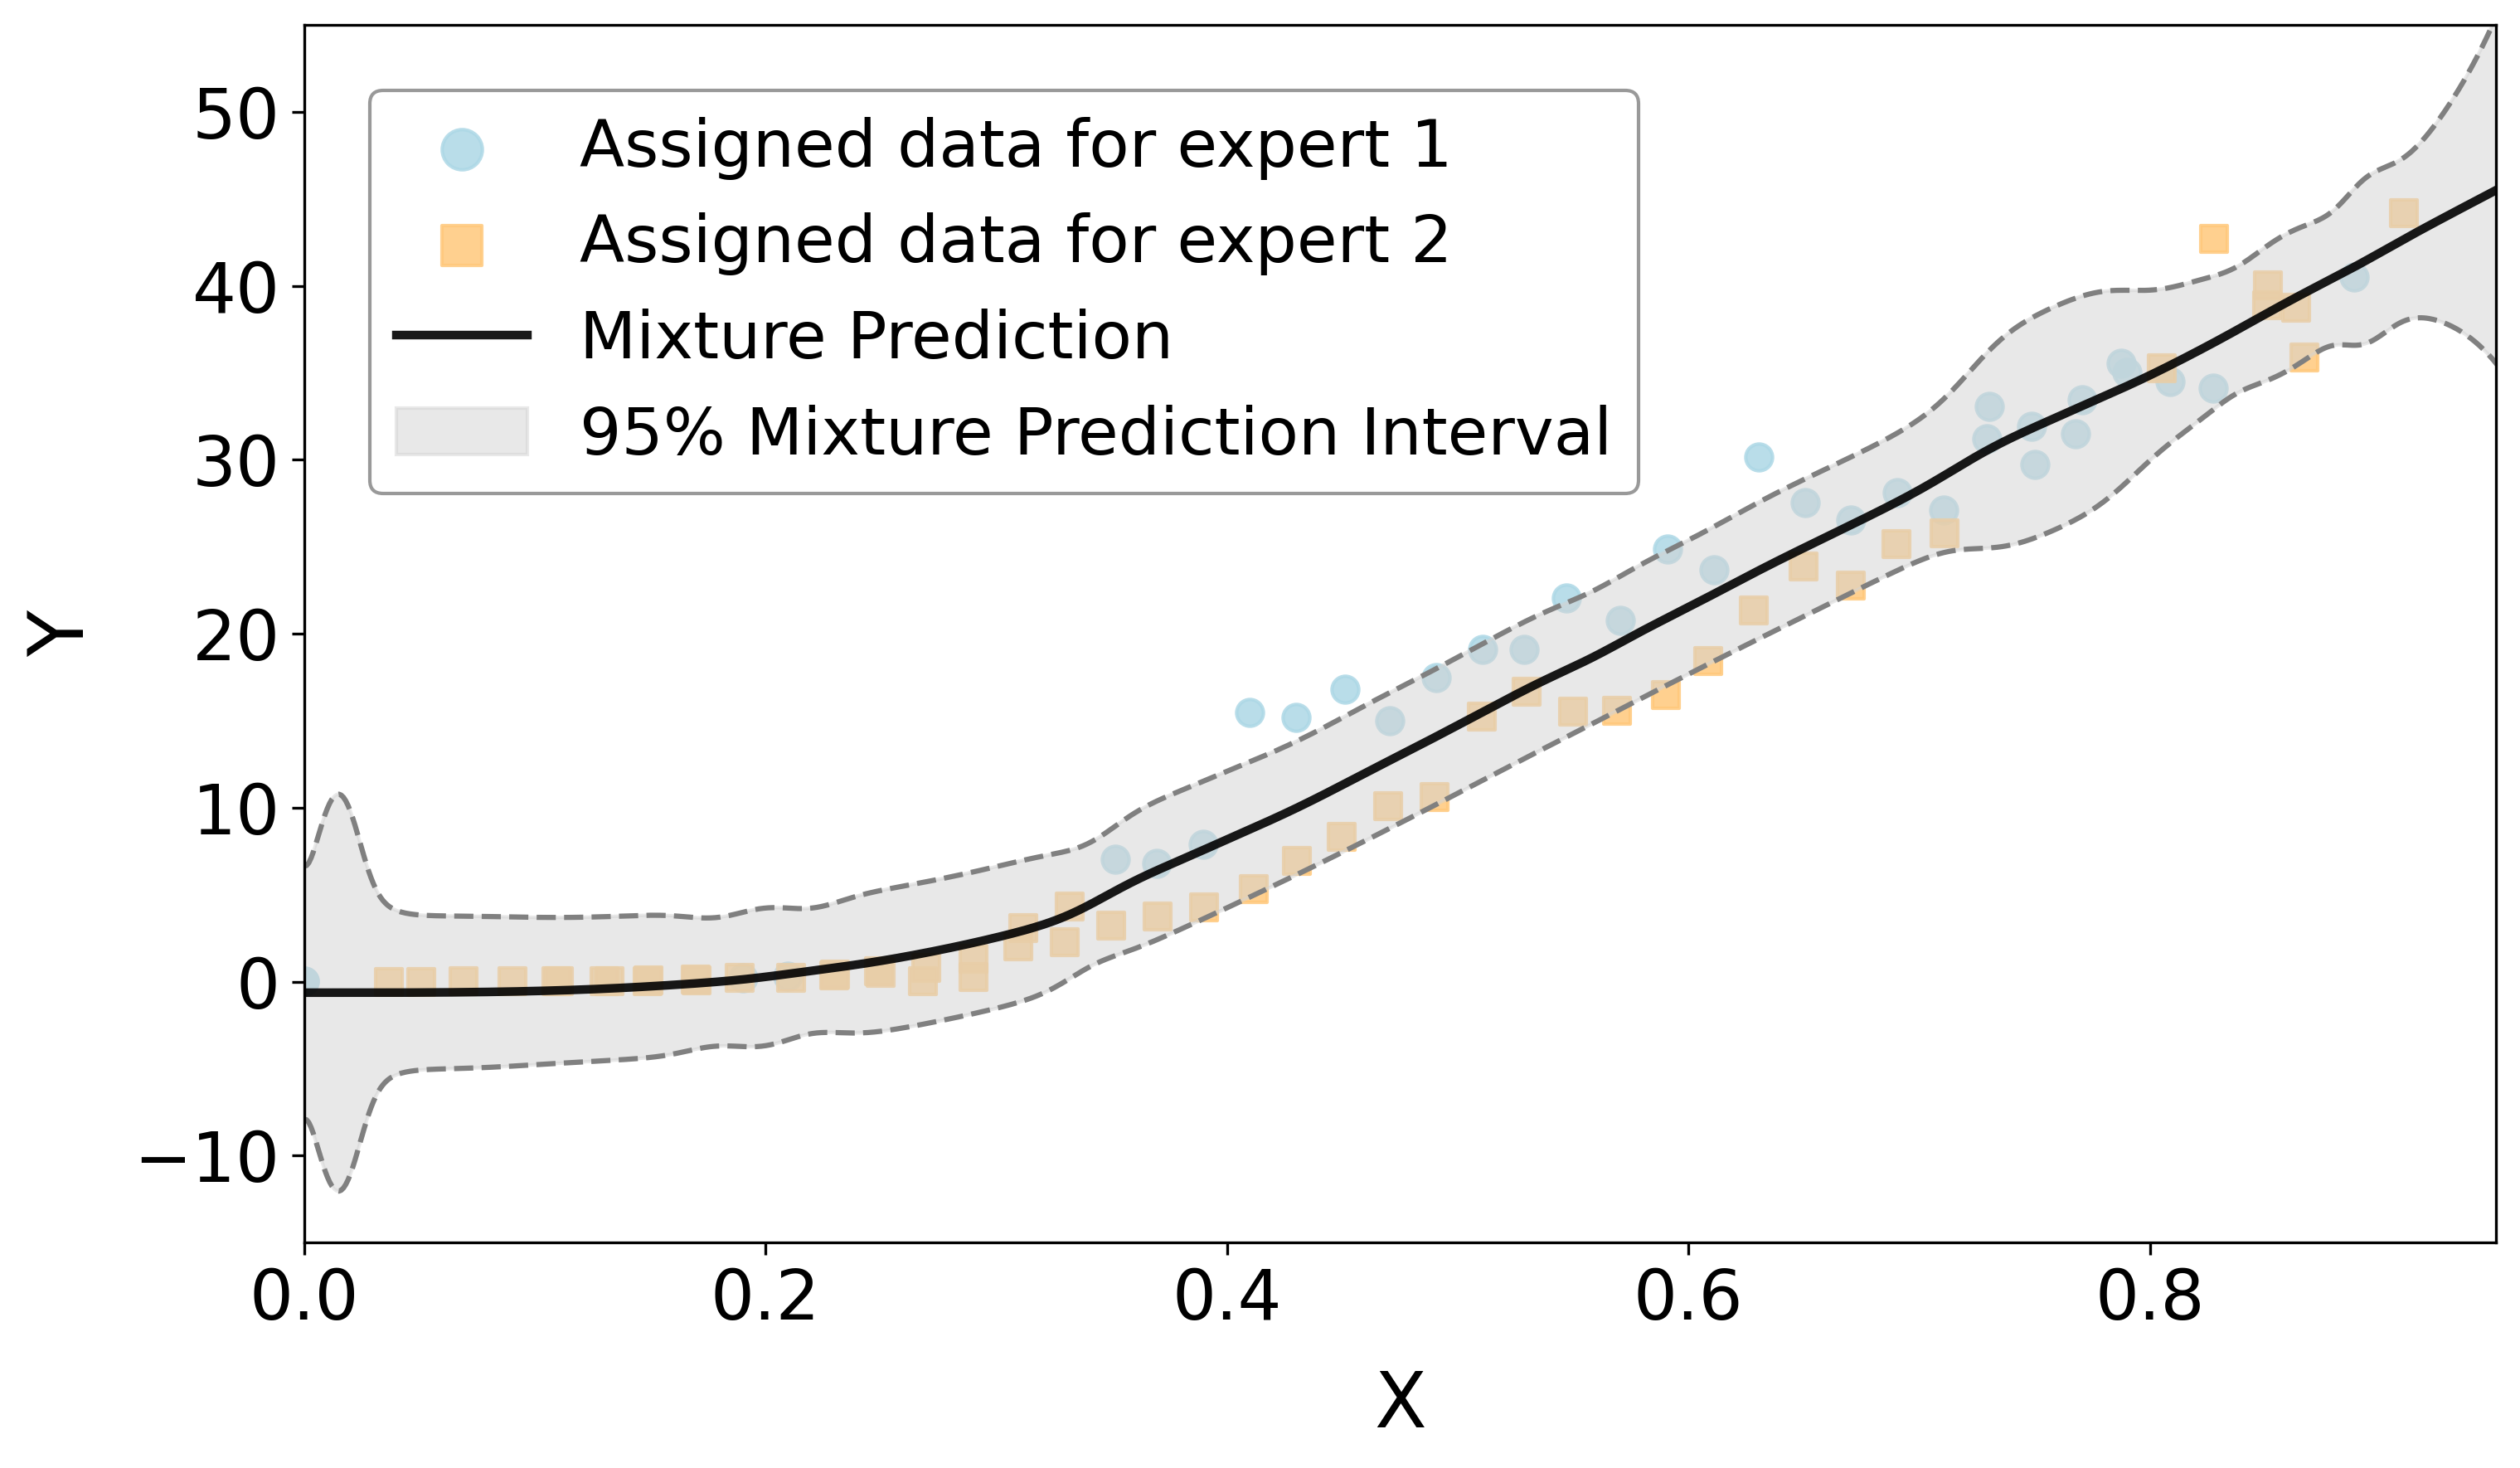

In [653]:
# initialize the mixture model
mixing = MOBP(X=mixed_X_train, Y=mixed_Y_train, alpha=0, num_init_clusters=2, num_iter=global_num_iter)
# fit the mixture model
if case_study != "turbine":
    temp_start = time.time()
    mixing.sample()
    temp_end = time.time()
    print(f'time took: {temp_end - temp_start} seconds')
else:
    with open("proposed_fitted_models/mixing_turbine_304_555_T167_IN425_leave_over.pkl", "rb") as f:
        mixing = pickle.load(f)

# generate what is needed for figure
plot_items = visualize_result2(mixing, mixed_X_train, mixed_Y_train, mixed_X_test=None, mixed_Y_test=None)

# generate the metrics
total_num_seeds = len(mixed_X_test)

mse_list = []
for test_i in range(0, total_num_seeds):
    plot_items_ = visualize_result2(mixing, mixed_X_train, mixed_Y_train, mixed_X_test=mixed_X_test[test_i], mixed_Y_test=mixed_Y_test[test_i], show_mono=False)
    mse_list.append(plot_items_[5])
    
print(f'average mse over {total_num_seeds} seeds is {sum(mse_list)/total_num_seeds}')
print(f'SE of mse is {np.std(mse_list)/np.sqrt(total_num_seeds)}')

# generate the figure
visualize_result(mixing.z, mixed_X_train, mixed_Y_train, option='both + mixture_pred', plot_mixture_pred=plot_items, case_study=case_study, save_file=save_file)


### 2. Standard GPR

Monotonicity Score: 0.9906765186765187


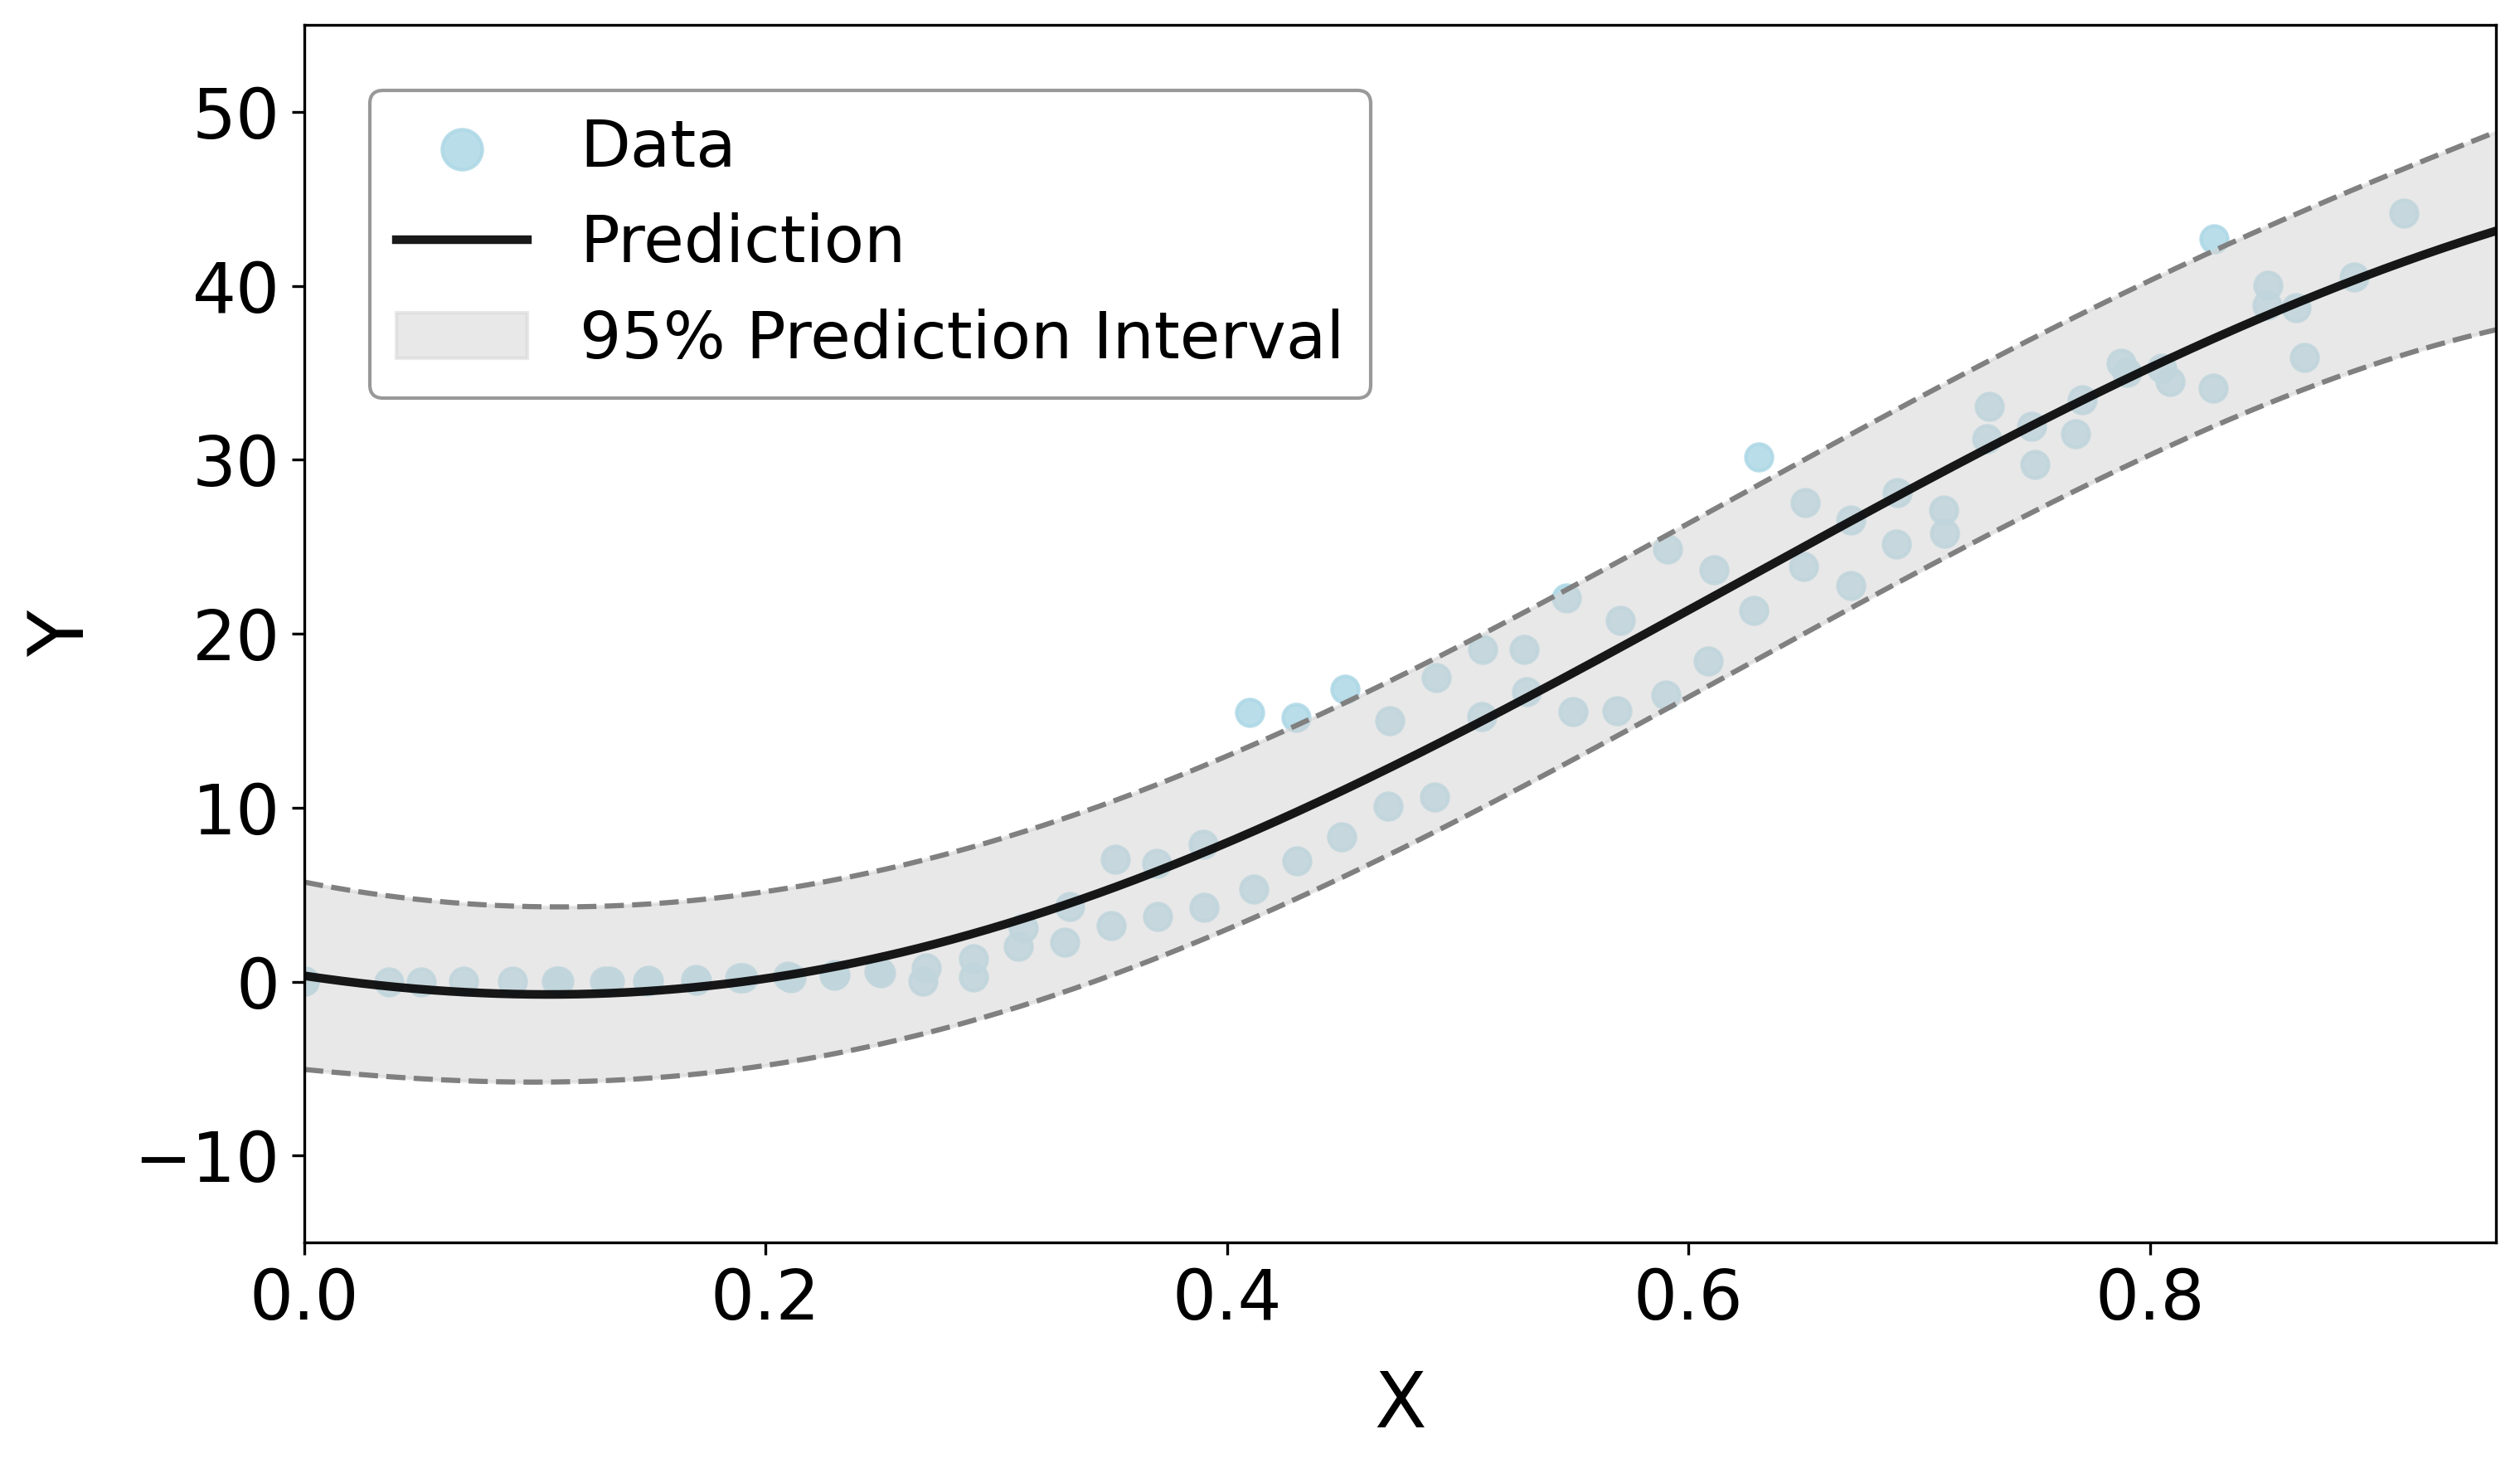

average mse over 30 seeds is 5.876310311797586
SE of mse is 0.018265817064016438


In [654]:
# generate the figure for GP
no_mixture(mixed_X=mixed_X_train, mixed_Y=mixed_Y_train, mixed_X_test=None, mixed_Y_test=None, plot_mixture_pred=True, case_study=case_study, save_file=save_file)

# generate the metrics for GP
total_num_seeds = len(mixed_X_test)

mse_list = []
for test_i in range(0, total_num_seeds):
    metrics_pred = no_mixture(mixed_X=mixed_X_train, mixed_Y=mixed_Y_train, mixed_X_test=mixed_X_test[test_i], mixed_Y_test=mixed_Y_test[test_i], show_mono=False, case_study=case_study)
    mse_list.append(metrics_pred[0])
    
print(f'average mse over {total_num_seeds} seeds is {sum(mse_list)/total_num_seeds}')
print(f'SE of mse is {np.std(mse_list)/np.sqrt(total_num_seeds)}')
